In [1]:
%pip install -qU keras_tuner nltk beautifulsoup4 matplotlib imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


## Dependencies

In [2]:
from bs4 import BeautifulSoup
from collections import Counter
from imblearn.over_sampling import SMOTE
import json
import keras_tuner as kt
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import os
import random
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

nltk.download("stopwords")

2023-12-04 10:31:23.581300: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
SEED = 42

tf.keras.utils.set_random_seed(SEED)

## Data

Load the dataset

In [4]:
with open('leetcode_problems_dataset.json', 'r') as f:
    problems = json.load(f)
    
len(problems)

2950

Get rid of HTML tags and extract just the text

In [5]:
problems["two-sum"]

{'difficulty': 'Easy',
 'content': '<p>Given an array of integers <code>nums</code>&nbsp;and an integer <code>target</code>, return <em>indices of the two numbers such that they add up to <code>target</code></em>.</p>\n\n<p>You may assume that each input would have <strong><em>exactly</em> one solution</strong>, and you may not use the <em>same</em> element twice.</p>\n\n<p>You can return the answer in any order.</p>\n\n<p>&nbsp;</p>\n<p><strong class="example">Example 1:</strong></p>\n\n<pre>\n<strong>Input:</strong> nums = [2,7,11,15], target = 9\n<strong>Output:</strong> [0,1]\n<strong>Explanation:</strong> Because nums[0] + nums[1] == 9, we return [0, 1].\n</pre>\n\n<p><strong class="example">Example 2:</strong></p>\n\n<pre>\n<strong>Input:</strong> nums = [3,2,4], target = 6\n<strong>Output:</strong> [1,2]\n</pre>\n\n<p><strong class="example">Example 3:</strong></p>\n\n<pre>\n<strong>Input:</strong> nums = [3,3], target = 6\n<strong>Output:</strong> [0,1]\n</pre>\n\n<p>&nbsp;</p>

Premium problems don't have content (since I'm not a premium user)

In [6]:
problems_without_html = []
for problem_name, problem_data in problems.items():
    if not problem_data["content"]:
        continue
    
    try:
        problems_without_html.append((BeautifulSoup(problem_data["content"], "html.parser").get_text(), problem_data["difficulty"]))
    except Exception as e:
        print(problem_name)
    
len(problems_without_html)

2366

In [7]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    pattern = r'\b\w+\b|`[^`]+`|\S' # words, numbers, symbols, and code-like elements
    tokens = re.findall(pattern, text)
    
    # remove punctuation
    # TODO: leave mathematical symbols
    tokens = [token for token in tokens if all(c not in string.punctuation for c in token)]
    
    # lowercase
    tokens = [t.lower() for t in tokens]
    
    # replace numbers with NUMBER token
    tokens = ['<NUMBER>' if re.match(r"^\d+$", token) else token for token in tokens]
    
    # remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    return tokens

In [8]:
problems_preprocessed = [(preprocess(text), difficulty) for text, difficulty in problems_without_html]

random.choice(problems_preprocessed)

(['binary',
  'matrix',
  'matrix',
  'elements',
  'either',
  '<NUMBER>',
  '<NUMBER>',
  'given',
  'quadtree1',
  'quadtree2',
  'quadtree1',
  'represents',
  'n',
  'n',
  'binary',
  'matrix',
  'quadtree2',
  'represents',
  'another',
  'n',
  'n',
  'binary',
  'matrix',
  'return',
  'quad',
  'tree',
  'representing',
  'n',
  'n',
  'binary',
  'matrix',
  'result',
  'logical',
  'bitwise',
  'two',
  'binary',
  'matrixes',
  'represented',
  'quadtree1',
  'quadtree2',
  'notice',
  'assign',
  'value',
  'node',
  'true',
  'false',
  'isleaf',
  'false',
  'accepted',
  'answer',
  'quad',
  'tree',
  'tree',
  'data',
  'structure',
  'internal',
  'node',
  'exactly',
  'four',
  'children',
  'besides',
  'node',
  'two',
  'attributes',
  'val',
  'true',
  'node',
  'represents',
  'grid',
  '<NUMBER>',
  'false',
  'node',
  'represents',
  'grid',
  '<NUMBER>',
  'isleaf',
  'true',
  'node',
  'leaf',
  'node',
  'tree',
  'false',
  'node',
  'four',
  'child

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text for text, _ in problems_preprocessed])
sequences = tokenizer.texts_to_sequences([text for text, _ in problems_preprocessed])
vocab_size = len(tokenizer.word_index) + 1

# pad all vectors to 90 percentile max length
max_length = int(np.percentile([len(seq) for seq in sequences], 90))
X = pad_sequences(sequences, maxlen=max_length, padding='post')

difficulties_int = { "Easy": 0, "Medium": 1, "Hard": 2 }
y = [difficulties_int[difficulty] for _, difficulty in problems_preprocessed]


random.choice(X)

array([  10,   61,   66,   38,    9, 2258,  281,   34,  592,   39,   42,
         73,   49,   45,   45,   49,  131,  281, 2451,    2,    1,    3,
         61,    1,    1,    1,   26,   26,    1,    1,    4,    1,    1,
          1,    1,    1,    2,    1,    3,   61,    1,    4,    1,    2,
          1,    3,   61,    4,   13,   12,   39,   38,   82,    1,    1,
          1,   20,  109,    1,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### Prepare training, validation and test datasets

Let's see the distribution of difficulties of problems

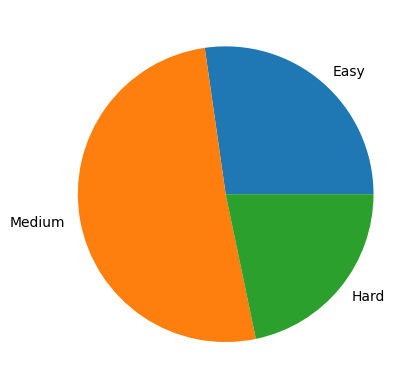

In [10]:
difficulty_counts = Counter(y)
total_count = sum(difficulty_counts.values())

plt.pie([count / total_count for count in difficulty_counts.values()], labels=["Easy", "Medium", "Hard"])
plt.show()

Generate balanced batches

In [11]:
# 70:15:15 train:validation:test, stratify is there to preserve the real world ratio in validation and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=SEED, stratify=y_val)

# for convenience
X_train, X_val, X_test, y_train, y_val, y_test = np.array(X_train), np.array(X_val), np.array(X_test), np.array(y_train), np.array(y_val), np.array(y_test)
print(f"{len(X_train)=}, {len(X_val)=}, {len(X_test)=}")

len(X_train)=1656, len(X_val)=355, len(X_test)=355


Oversampling technique of the minority class, common approach to handle imbalanced datasets

In [12]:
smote = SMOTE(random_state=SEED)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

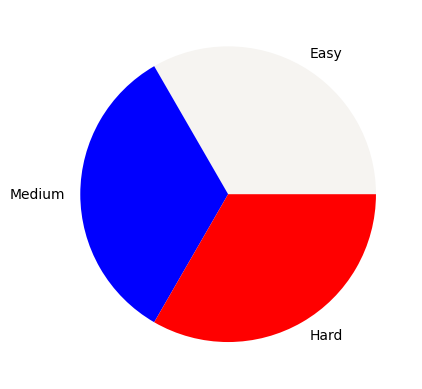

In [13]:
difficulty_counts_train_smote = Counter(y_train_smote)
total_count_train_smote = sum(difficulty_counts_train_smote.values())

plt.pie([count / total_count_train_smote for count in difficulty_counts_train_smote.values()], labels=["Easy", "Medium", "Hard"], colors=["#F6F4F1", "blue", "red"])
plt.show()

In [14]:
BATCH_SIZE = 16

train = tf.data.Dataset.from_tensor_slices((X_train_smote, y_train_smote)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2023-12-04 10:31:32.855874: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43683 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:61:00.0, compute capability: 8.6


## Build RNN

In [15]:
def rnn_block(input, units, dropout_rate, recurrent_dropout, hp_rnn_type, return_sequences=True):
    if hp_rnn_type == 'lstm':
        rnn_layer = tf.keras.layers.LSTM(units, dropout=dropout_rate, recurrent_dropout=recurrent_dropout, return_sequences=return_sequences)(input)
    elif hp_rnn_type == 'gru':
        rnn_layer = tf.keras.layers.GRU(units, dropout=dropout_rate, recurrent_dropout=recurrent_dropout, return_sequences=return_sequences)(input)
    else:
        raise ValueError("Invalid RNN type")

    return rnn_layer

In [16]:
def build_model(hp):
    input = tf.keras.layers.Input(shape=(max_length,))

    hp_embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=256, step=32)
    embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=hp_embedding_dim, mask_zero=True)(input)
    # now 3d - (batch_size, sequence, embed_dim)
    
    hp_units = hp.Int(f'rnn_units', min_value=32, max_value=256, step=32)
    hp_dropout = hp.Choice(f'rnn_dropout', values=[.2, .3, .4, .5])
    hp_recurrent_dropout = hp.Choice(f'rnn_recurrent_dropout', values=[.2, .3, .4, .5])
    hp_rnn_type = hp.Choice(f'rnn_type', values=['lstm', 'gru'])
    
    if hp_rnn_type == 'lstm':
        rnn = tf.keras.layers.LSTM(hp_units, dropout=hp_dropout, recurrent_dropout=hp_recurrent_dropout, return_sequences=False)(embedding)
    elif hp_rnn_type == 'gru':
        rnn = tf.keras.layers.GRU(hp_units, dropout=hp_dropout, recurrent_dropout=hp_recurrent_dropout, return_sequences=False)(embedding)

    output = tf.keras.layers.Dense(units=3, activation=tf.nn.softmax)(rnn)
    model = tf.keras.Model(inputs=input, outputs=output)

    hp_learning_rate = hp.Choice('learning_rate', values=[.01, .005, .001])
    hp_sgd_momentum = hp.Choice('sgd_momentum', values=[.8, .9])
    hp_optimizer_name = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop', 'adagrad'])

    if hp_optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer_name == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate, momentum=hp_sgd_momentum, nesterov=True)
    elif hp_optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    elif hp_optimizer_name == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=hp_learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    return model

## Train RNN

Set up hyper search using the hyper band algorithm

In [17]:
tuner = kt.Hyperband(
    build_model,
    objective='val_sparse_categorical_accuracy',
    directory='rnn_model',
    seed=SEED
)

Reloading Tuner from rnn_model/untitled_project/tuner0.json


Start search for the best hyperparameters given the current datasets

In [18]:
tuner.search(
    train,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=10
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=3,
            verbose=1,
            restore_best_weights=True
        )
    ],
    validation_data=validation
)

Trial 246 Complete [00h 09m 07s]
val_sparse_categorical_accuracy: 0.21690140664577484

Best val_sparse_categorical_accuracy So Far: 0.5211267471313477
Total elapsed time: 2d 02h 42m 54s


Extract hyperparameters from the best trial and store them

In [19]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_hps = best_trial.hyperparameters

with open('rnn_best_hp.json', 'w') as f:
    json.dump(best_hps.values, f)

In [20]:
best_model = tuner.hypermodel.build(best_hps)

best_model.fit(
    train,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=10
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=3,
            verbose=1,
            restore_best_weights=True
        )
    ],
    validation_data=validation
)

Epoch 1/100
159/159 [==============================] - 125s 778ms/step - loss: 1.1017 - sparse_categorical_accuracy: 0.3207 - val_loss: 1.0848 - val_sparse_categorical_accuracy: 0.4817 - lr: 0.0010
Epoch 2/100
159/159 [==============================] - 116s 730ms/step - loss: 1.0962 - sparse_categorical_accuracy: 0.3404 - val_loss: 1.0825 - val_sparse_categorical_accuracy: 0.4789 - lr: 0.0010
Epoch 3/100
159/159 [==============================] - 113s 713ms/step - loss: 1.0940 - sparse_categorical_accuracy: 0.3495 - val_loss: 1.0808 - val_sparse_categorical_accuracy: 0.4789 - lr: 0.0010
Epoch 4/100
159/159 [==============================] - 114s 716ms/step - loss: 1.0914 - sparse_categorical_accuracy: 0.3641 - val_loss: 1.0793 - val_sparse_categorical_accuracy: 0.4845 - lr: 0.0010
Epoch 5/100
159/159 [==============================] - 110s 690ms/step - loss: 1.0900 - sparse_categorical_accuracy: 0.3803 - val_loss: 1.0779 - val_sparse_categorical_accuracy: 0.4873 - lr: 0.0010
Epoch 6/10

In [21]:
best_model.evaluate(X_test, y_test)

12/12 [==============================] - 1s 56ms/step - loss: 1.0841 - sparse_categorical_accuracy: 0.4254


[1.0841212272644043, 0.4253521263599396]

In [22]:
predictions = best_model.predict(X_test)
predictions

12/12 [==============================] - 1s 49ms/step


array([[0.188, 0.664, 0.148],
       [0.386, 0.189, 0.426],
       [0.262, 0.512, 0.226],
       ...,
       [0.219, 0.598, 0.183],
       [0.329, 0.395, 0.276],
       [0.282, 0.466, 0.252]], dtype=float32)

In [23]:
best_model.save('rnn_smote.h5')